## Project: Dynamic Classifier Selection in Imbalanced Data Scenarios

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## Dynamic Classifier Selection Algorithms
- **Custom-OLA (Overall Local Accuracy)**

- **LCA (Local Class Accuracy)**

- **META-DES (Synthetic Minority Over-sampling Technique)**

Base Classifiers

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = [GaussianNB(), KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier()]


In [7]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

class CustomOla:
    def __init__(self, classifiers, n_neighbors=5):
        self.classifiers = classifiers
        self.n_neighbors = n_neighbors
        self.nn = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.nn.fit(X_train)

    def predict(self, X_test):
        if self.nn is None:
            raise Exception("Model must be fitted before prediction.")

        predictions = []
        
        for test_instance in X_test:
            _, neighbor_indices = self.nn.kneighbors([test_instance])
            neighbor_indices = neighbor_indices.flatten()
            
            local_accuracies = []
            for clf in self.classifiers:
                local_preds = clf.predict(self.X_train[neighbor_indices])
                local_accuracy = np.mean(local_preds == self.y_train[neighbor_indices])
                local_accuracies.append(local_accuracy)
            
            best_clf_index = np.argmax(local_accuracies)
            best_clf = self.classifiers[best_clf_index]
            prediction = best_clf.predict([test_instance])
            predictions.append(prediction[0])
        
        return np.array(predictions)


In [8]:
from deslib.dcs.lca import LCA
import numpy as np


def LCA_train_and_predict(pool_classifiers, X_train, y_train, X_test):
    lca = LCA(pool_classifiers)
    lca.fit(X_train, y_train)

    predictions = lca.predict(X_test)

    return np.array(predictions)

In [9]:
from deslib.des.meta_des import METADES
import numpy as np


def META_DES_train_and_predict(pool_classifiers,X_train, y_train, X_test):
    metades = METADES(pool_classifiers)
    metades.fit(X_train, y_train)

    predictions = metades.predict(X_test)

    return np.array(predictions)




In [10]:
datasets_path = 'datasets_norm'
dataset_names = os.listdir(datasets_path)

datasets = []
imbalance_ratios_list = []  
for file_name in dataset_names:
    path = os.path.join(datasets_path, file_name)
    data = np.genfromtxt(path, delimiter=',', skip_header=1)
    datasets.append((file_name, data))

for idx, (name, data) in enumerate(datasets):
    
    X = data[:, :-1] 
    y = data[:, -1]

    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    imbalance_ratios = np.round(counts / total_samples, 2)
    imbalance_ratio = np.round(min(counts) / total_samples, 2)  

    # Store the imbalance ratio
    imbalance_ratios_list.append(imbalance_ratio)

    print(f"Dataset ID: {idx}")
    print(f"Dataset Name: {name}")
    print(f"Number of Features: {X.shape[1]}")
    print("Class Counts:", dict(zip(classes, counts)))
    print("Imbalance Ratios:", dict(zip(classes, imbalance_ratios)))
    print("\n")




Dataset ID: 0
Dataset Name: 9_us_crime.csv
Number of Features: 100
Class Counts: {-1.0: 1844, 1.0: 150}
Imbalance Ratios: {-1.0: 0.92, 1.0: 0.08}


Dataset ID: 1
Dataset Name: 12_libras_move.csv
Number of Features: 90
Class Counts: {-1.0: 336, 1.0: 24}
Imbalance Ratios: {-1.0: 0.93, 1.0: 0.07}


Dataset ID: 2
Dataset Name: 5_sick_euthyroid.csv
Number of Features: 42
Class Counts: {-1.0: 2870, 1.0: 293}
Imbalance Ratios: {-1.0: 0.91, 1.0: 0.09}


Dataset ID: 3
Dataset Name: 17_oil.csv
Number of Features: 49
Class Counts: {-1.0: 896, 1.0: 41}
Imbalance Ratios: {-1.0: 0.96, 1.0: 0.04}


Dataset ID: 4
Dataset Name: 16_solar_flare_m0.csv
Number of Features: 32
Class Counts: {-1.0: 1321, 1.0: 68}
Imbalance Ratios: {-1.0: 0.95, 1.0: 0.05}


Dataset ID: 5
Dataset Name: 1_optical_digits.csv
Number of Features: 64
Class Counts: {-1.0: 5066, 1.0: 554}
Imbalance Ratios: {-1.0: 0.9, 1.0: 0.1}


Dataset ID: 6
Dataset Name: 7_car_eval_34.csv
Number of Features: 21
Class Counts: {-1.0: 1594, 1.0: 134}

Applying DCS Algorithms


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

results = []

for i, (name, dataset) in enumerate(datasets):
    X, y = dataset[:, :-1], dataset[:, -1]
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    ola_predictions_all = []
    lca_predictions_all = []
    metades_predictions_all = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        tuned_classifiers = []
        for clf in classifiers:
            if isinstance(clf, DecisionTreeClassifier):
                best_accuracy = 0
                best_depth = 1
                for depth in range(2, 10):
                    temp_clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
                    scores = cross_val_score(temp_clf, X_train, y_train, cv=5, scoring='f1_weighted')
                    accuracy = scores.mean()
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_depth = depth
                tuned_classifiers.append(DecisionTreeClassifier(max_depth=best_depth, random_state=42))
            elif isinstance(clf, KNeighborsClassifier):
                best_accuracy = 0
                best_n_neighbors = 1
                for n in range(1, 15):
                    temp_clf = KNeighborsClassifier(n_neighbors=n)
                    scores = cross_val_score(temp_clf, X_train, y_train, cv=5, scoring='f1_weighted')
                    accuracy = scores.mean()
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_n_neighbors = n
                tuned_classifiers.append(KNeighborsClassifier(n_neighbors=best_n_neighbors))

            elif isinstance(clf, GaussianNB):
                best_accuracy = 0
                best_var_smoothing = 1e-9
                for var_sm in np.logspace(-10, -9, 100):
                    temp_clf = GaussianNB(var_smoothing=var_sm)
                    scores = cross_val_score(temp_clf, X_train, y_train, cv=5, scoring='f1_weighted')
                    accuracy = scores.mean()
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_var_smoothing = var_sm
                tuned_classifiers.append(GaussianNB(var_smoothing=best_var_smoothing))

        for clf in tuned_classifiers:
            clf.fit(X_train, y_train)

        custom_ola = CustomOla(tuned_classifiers)
        custom_ola.fit(X_train, y_train)
        ola_predictions = custom_ola.predict(X_test)
        ola_predictions_all.extend(ola_predictions)

        lca = LCA(tuned_classifiers)
        lca.fit(X_train, y_train)
        lca_predictions = lca.predict(X_test)
        lca_predictions_all.extend(lca_predictions)

        metades = METADES(tuned_classifiers)
        metades.fit(X_train, y_train)
        metades_predictions = metades.predict(X_test)
        metades_predictions_all.extend(metades_predictions)

    results.append({
        'dataset': name,
        'y_test': y,  
        'ola_predictions': np.array(ola_predictions_all),
        'lca_predictions': np.array(lca_predictions_all),
        'metades_predictions': np.array(metades_predictions_all)
    })



# Model Evaluation
In this section, we evaluate the performance of the machine learning models on imbalanced datasets. The evaluation process includes:

- **F1 Score Calculation**: The F1 score.  

- **Matthews Corrcoef Calculation**


In [23]:
from sklearn.metrics import f1_score, matthews_corrcoef
import numpy as np

def evaluate_models_f1_score(results):
    f1_scores = {}
    method_totals = {'ola_predictions': [], 'lca_predictions': [], 'metades_predictions': []}

    for result in results:
        dataset_name = result['dataset']
        true_labels = result['y_test']
        f1_scores[dataset_name] = {}
        for method in method_totals.keys():
            predictions = result[method]
            score = f1_score(true_labels, predictions, average='weighted')
            f1_scores[dataset_name][method] = score
            method_totals[method].append(score)

    averages = {method: np.mean(scores) for method, scores in method_totals.items()}
    std_devs = {method: np.std(scores) for method, scores in method_totals.items()}

    return f1_scores, averages, std_devs

def evaluate_models_mcc(results):
    mcc_scores = {}
    method_totals = {'ola_predictions': [], 'lca_predictions': [], 'metades_predictions': []}

    for result in results:
        dataset_name = result['dataset']
        true_labels = result['y_test']
        mcc_scores[dataset_name] = {}
        for method in method_totals.keys():
            predictions = result[method]
            score = matthews_corrcoef(true_labels, predictions)
            mcc_scores[dataset_name][method] = score
            method_totals[method].append(score)

    averages = {method: np.mean(scores) for method, scores in method_totals.items()}
    std_devs = {method: np.std(scores) for method, scores in method_totals.items()}

    return mcc_scores, averages, std_devs


In [24]:
f1_scores, f1_averages, f1_std_devs = evaluate_models_f1_score(results)
mcc_scores, mcc_averages, mcc_std_devs = evaluate_models_mcc(results)

print("F1 Scores:")
for dataset in f1_scores:
    print(f"{dataset}:")
    for method, score in f1_scores[dataset].items():
        print(f"  {method}: {score}")

print("\nAverage F1 Scores and Standard Deviations:")
for method in f1_averages:
    print(f"{method} - Average: {f1_averages[method]}, Std Dev: {f1_std_devs[method]}")

print("\nMatthews Correlation Coefficient Scores:")
for dataset in mcc_scores:
    print(f"{dataset}:")
    for method, score in mcc_scores[dataset].items():
        print(f"  {method}: {score}")

print("\nAverage Matthews Correlation Coefficient Scores and Standard Deviations:")
for method in mcc_averages:
    print(f"{method} - Average: {mcc_averages[method]}, Std Dev: {mcc_std_devs[method]}")


F1 Scores:
9_us_crime.csv:
  ola_predictions: 0.8673061142814953
  lca_predictions: 0.829699737556755
  metades_predictions: 0.8692335524994902
12_libras_move.csv:
  ola_predictions: 0.8992274195814017
  lca_predictions: 0.8849841400314039
  metades_predictions: 0.8949794652585701
5_sick_euthyroid.csv:
  ola_predictions: 0.8385434647797863
  lca_predictions: 0.7624820421328887
  metades_predictions: 0.837794994680052
17_oil.csv:
  ola_predictions: 0.9309250722605238
  lca_predictions: 0.8785817134136067
  metades_predictions: 0.9297034661580098
16_solar_flare_m0.csv:
  ola_predictions: 0.9217912638319452
  lca_predictions: 0.8736389939132427
  metades_predictions: 0.9274888367904927
1_optical_digits.csv:
  ola_predictions: 0.8246643290669209
  lca_predictions: 0.8209572084380338
  metades_predictions: 0.8219893781113589
7_car_eval_34.csv:
  ola_predictions: 0.8654101188711287
  lca_predictions: 0.8474553882749563
  metades_predictions: 0.8619987949707982
18_car_eval_4.csv:
  ola_predic

In [14]:
np.save('f1_scores.npy', f1_scores)


# Visualization of Results

The final section provides visualizations of the model F1 accuracies for analysis across datasets.
- bar chart 
- scatter plot


In [25]:
import matplotlib.pyplot as plt
import numpy as np

imbalance_ratios = imbalance_ratios_list 

ola_f1_scores = [f1_scores[dataset]['ola_predictions'] for dataset in f1_scores]
lca_f1_scores = [f1_scores[dataset]['lca_predictions'] for dataset in f1_scores]
metades_f1_scores = [f1_scores[dataset]['metades_predictions'] for dataset in f1_scores]

ola_mcc_scores = [mcc_scores[dataset]['ola_predictions'] for dataset in mcc_scores]
lca_mcc_scores = [mcc_scores[dataset]['lca_predictions'] for dataset in mcc_scores]
metades_mcc_scores = [mcc_scores[dataset]['metades_predictions'] for dataset in mcc_scores]


dataset_names = [dataset for dataset in f1_scores]

print(ola_f1_scores)
print(lca_f1_scores)
print(metades_f1_scores)
print(ola_mcc_scores)
print(lca_mcc_scores)
print(metades_mcc_scores)




[0.8673061142814953, 0.8992274195814017, 0.8385434647797863, 0.9309250722605238, 0.9217912638319452, 0.8246643290669209, 0.8654101188711287, 0.9320277876935174, 0.8166066606660666, 0.8825477545204337, 0.9078232608974117, 0.8271298165035645, 0.8282495591665129, 0.8905916306859434, 0.8604024778239446, 0.8426065754950182, 0.9066417507663167, 0.8828902007032451, 0.8443201164621975, 0.9393571392481191]
[0.829699737556755, 0.8849841400314039, 0.7624820421328887, 0.8785817134136067, 0.8736389939132427, 0.8209572084380338, 0.8474553882749563, 0.9270833333333334, 0.7561307990528972, 0.846923276467211, 0.7715307442670656, 0.8281254493970418, 0.7956281307983091, 0.8438858436694132, 0.8354783507931162, 0.8518255898794486, 0.8369442505657343, 0.8185619155449391, 0.7539579399477926, 0.93789927629935]
[0.8692335524994902, 0.8949794652585701, 0.837794994680052, 0.9297034661580098, 0.9274888367904927, 0.8219893781113589, 0.8619987949707982, 0.9298649487239852, 0.8190919213329398, 0.8816699271085403, 0.

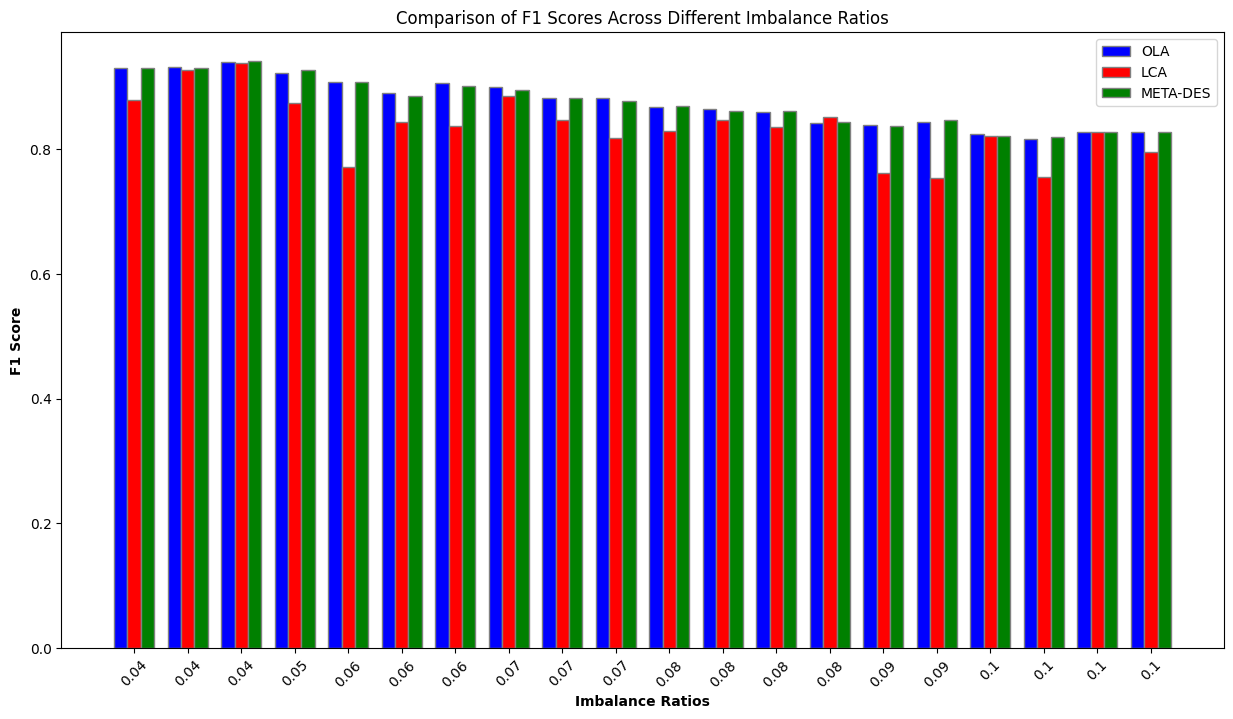

In [26]:
barWidth = 0.25

combined_data = list(zip(imbalance_ratios, ola_f1_scores, lca_f1_scores, metades_f1_scores))

# Sorting the data by imbalance ratios
combined_data.sort(key=lambda x: x[0])

# Extracting the sorted data
sorted_imbalance_ratios, sorted_ola_f1_scores, sorted_lca_f1_scores, sorted_metades_f1_scores = zip(*combined_data)

r1 = np.arange(len(sorted_ola_f1_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(15, 8))
plt.bar(r1, sorted_ola_f1_scores, color='b', width=barWidth, edgecolor='grey', label='OLA')
plt.bar(r2, sorted_lca_f1_scores, color='r', width=barWidth, edgecolor='grey', label='LCA')
plt.bar(r3, sorted_metades_f1_scores, color='g', width=barWidth, edgecolor='grey', label='META-DES')

plt.xlabel('Imbalance Ratios', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(sorted_ola_f1_scores))], sorted_imbalance_ratios, rotation=45)
plt.title('Comparison of F1 Scores Across Different Imbalance Ratios')

plt.legend()

plt.savefig('bar_chart.png')
plt.show()

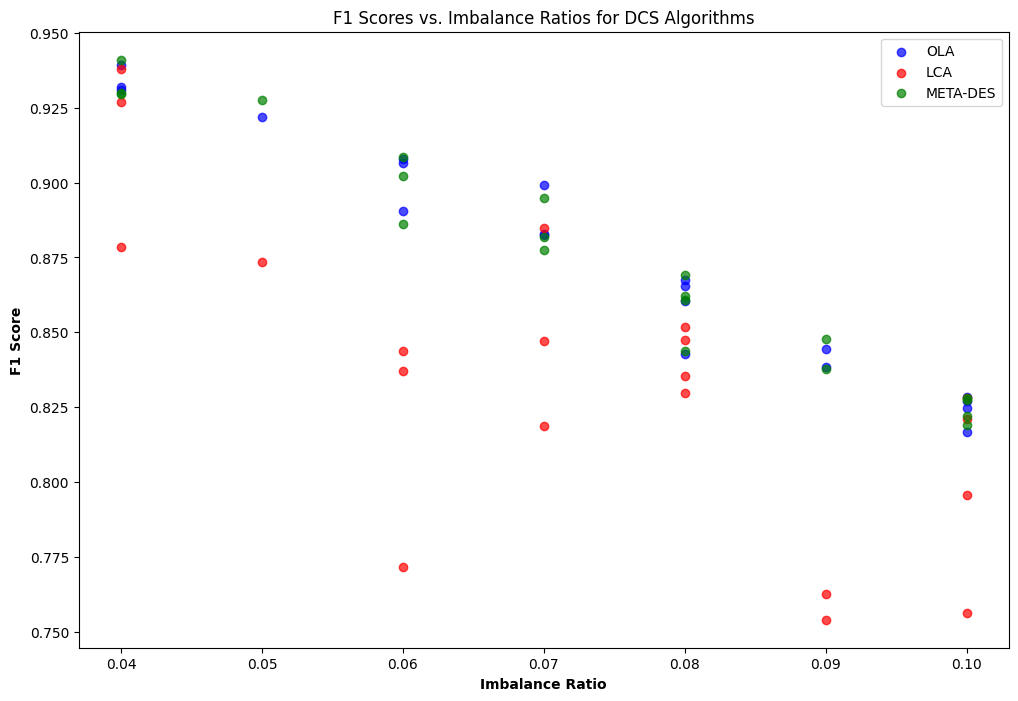

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.scatter(imbalance_ratios, ola_f1_scores, color='b', label='OLA', alpha=0.7)
plt.scatter(imbalance_ratios, lca_f1_scores, color='r', label='LCA', alpha=0.7)
plt.scatter(imbalance_ratios, metades_f1_scores, color='g', label='META-DES', alpha=0.7)

plt.xlabel('Imbalance Ratio', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.title('F1 Scores vs. Imbalance Ratios for DCS Algorithms')

plt.legend()

plt.savefig('scatter_plot.png')
plt.show()



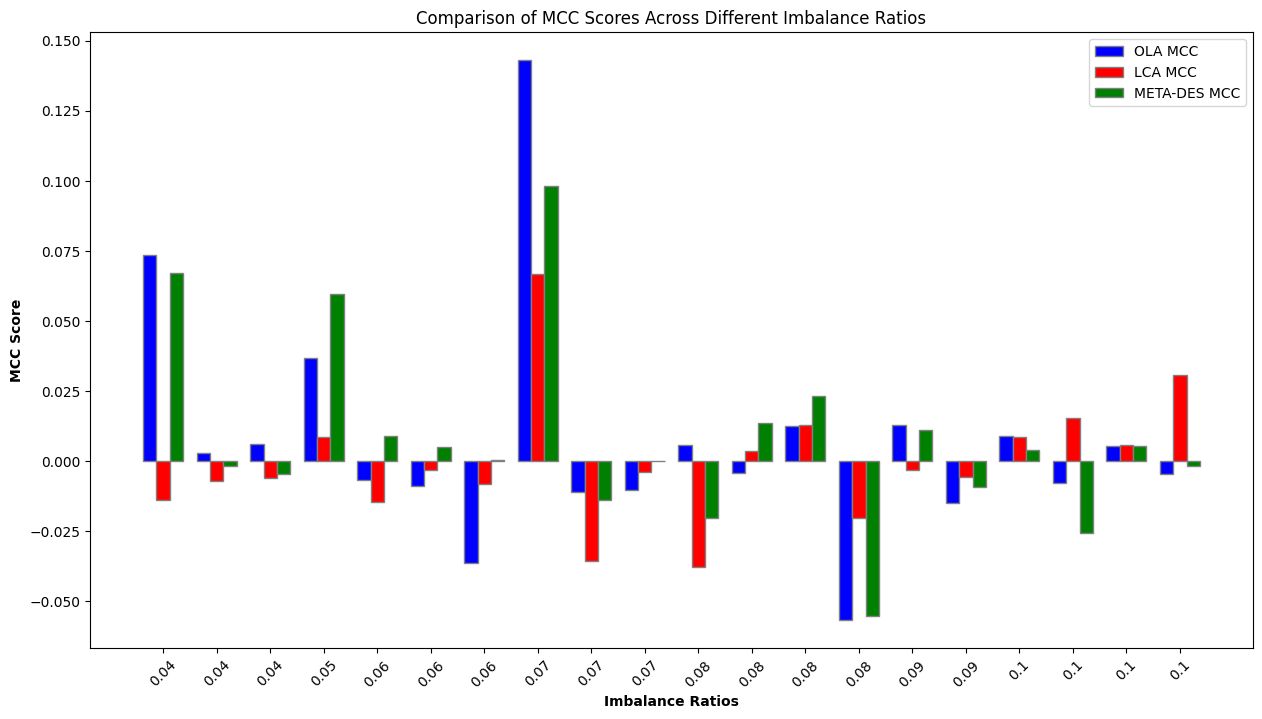

In [28]:
barWidth = 0.25

combined_data = list(zip(imbalance_ratios, ola_mcc_scores, lca_mcc_scores, metades_mcc_scores))
combined_data.sort(key=lambda x: x[0])
sorted_imbalance_ratios, sorted_ola_mcc_scores, sorted_lca_mcc_scores, sorted_metades_mcc_scores = zip(*combined_data)

r1 = np.arange(len(sorted_ola_mcc_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.figure(figsize=(15, 8))
plt.bar(r1, sorted_ola_mcc_scores, color='blue', width=barWidth, edgecolor='grey', label='OLA MCC')
plt.bar(r2, sorted_lca_mcc_scores, color='red', width=barWidth, edgecolor='grey', label='LCA MCC')
plt.bar(r3, sorted_metades_mcc_scores, color='green', width=barWidth, edgecolor='grey', label='META-DES MCC')
plt.xlabel('Imbalance Ratios', fontweight='bold')
plt.ylabel('MCC Score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(sorted_ola_mcc_scores))], sorted_imbalance_ratios, rotation=45)
plt.title('Comparison of MCC Scores Across Different Imbalance Ratios')

plt.legend()
plt.savefig('mcc_bar_chart.png')
plt.show()

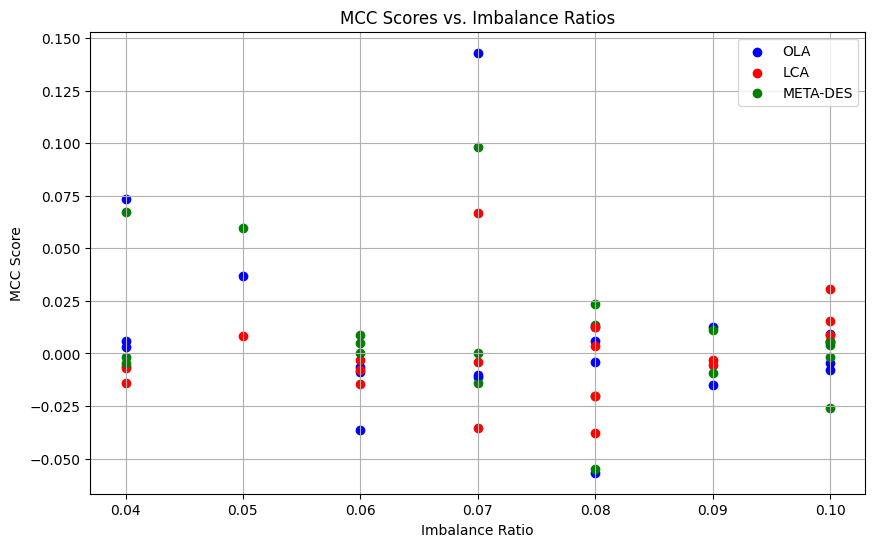

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for i, dataset in enumerate(mcc_scores.keys()):
    ir = imbalance_ratios[i] 
    plt.scatter(ir, mcc_scores[dataset]['ola_predictions'], color='blue', label='OLA' if i == 0 else "")
    plt.scatter(ir, mcc_scores[dataset]['lca_predictions'], color='red', label='LCA' if i == 0 else "")
    plt.scatter(ir, mcc_scores[dataset]['metades_predictions'], color='green', label='META-DES' if i == 0 else "")

plt.xlabel('Imbalance Ratio')
plt.ylabel('MCC Score')
plt.title('MCC Scores vs. Imbalance Ratios')
plt.legend()
plt.grid(True)
plt.savefig('mcc_scatter_plot.png')
plt.show()


Statistical Analysis

In [30]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np

f_value, p_value = stats.f_oneway(ola_f1_scores, lca_f1_scores, metades_f1_scores)

if p_value < 0.05:
    print(f"Significant differences found with F={f_value}, p={p_value}. Proceeding with post-hoc analysis.")
    
    all_scores = np.concatenate([ola_f1_scores, lca_f1_scores, metades_f1_scores])
    groups = ['OLA'] * len(ola_f1_scores) + ['LCA'] * len(lca_f1_scores) + ['META-DES'] * len(metades_f1_scores)

    tukey = pairwise_tukeyhsd(endog=all_scores, groups=groups, alpha=0.05)
    print(tukey.summary())
else:
    print(f"No significant differences found with F={f_value}, p={p_value}.")


Significant differences found with F=5.588913307657172, p=0.006075800952351784. Proceeding with post-hoc analysis.
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     LCA META-DES   0.0398 0.0155  0.0065  0.073   True
     LCA      OLA   0.0404 0.0138  0.0071 0.0737   True
META-DES      OLA   0.0006 0.9989 -0.0327 0.0339  False
-------------------------------------------------------
